# Assignment 20: Timeseries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("exchange_rate.csv")

In [3]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [6]:
df.shape

(7588, 2)

In [7]:
# Convert 'date' column to datetime and set as index
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df.set_index('date', inplace=True)

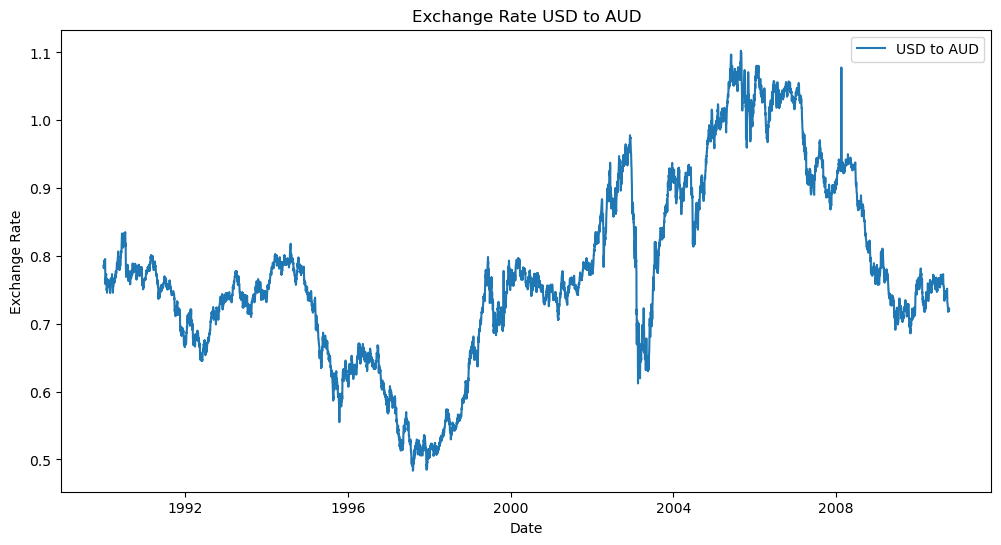

In [8]:
# Plot time series
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='USD to AUD')
plt.title('Exchange Rate USD to AUD')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

## 2. Data Preprocessing

In [9]:
df.isnull().sum()

Ex_rate    0
dtype: int64

In [10]:
# Fill missing values if any
df['Ex_rate'] = df['Ex_rate'].ffill()

## ARIMA Model

In [11]:
# Check stationarity
result = adfuller(df['Ex_rate'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


In [12]:
# If not stationary, take first difference
df_diff = df['Ex_rate'].diff().dropna()

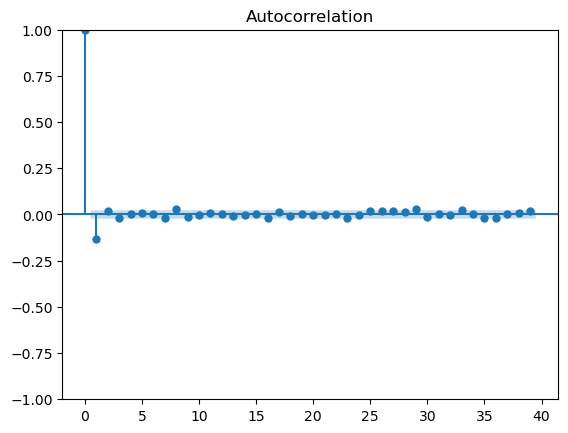

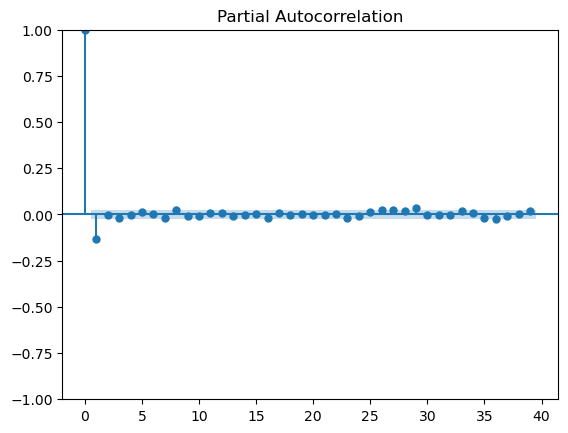

In [13]:
# Plot ACF and PACF to estimate p and q
plot_acf(df_diff)
plt.show()
plot_pacf(df_diff)
plt.show()

In [14]:
# Fit ARIMA model (example: p=1, d=1, q=1 - adjust based on ACF/PACF)
arima_model = ARIMA(df['Ex_rate'], order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

E:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 28 Sep 2025   AIC                         -56102.322
Time:                        20:14:34   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

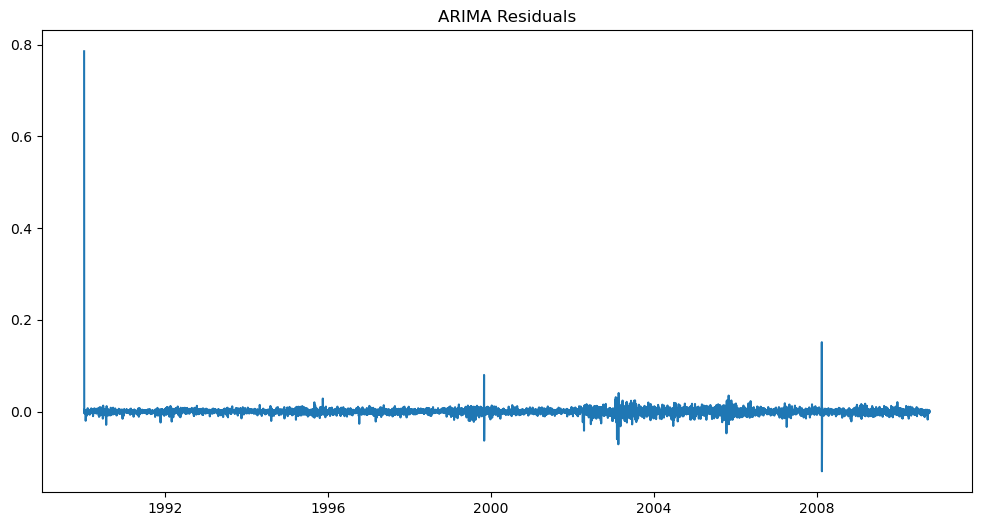

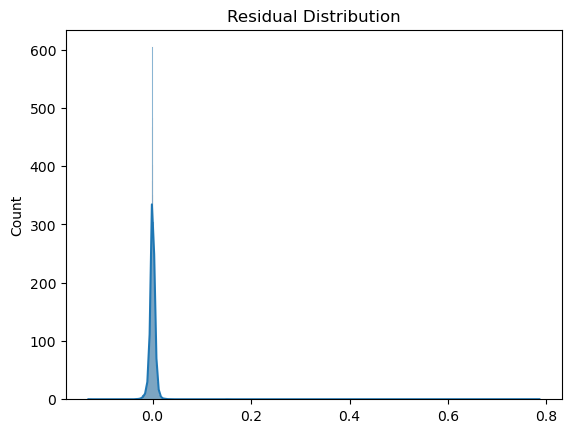

In [15]:
# Residual diagnostics
residuals = arima_result.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('ARIMA Residuals')
plt.show()
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()

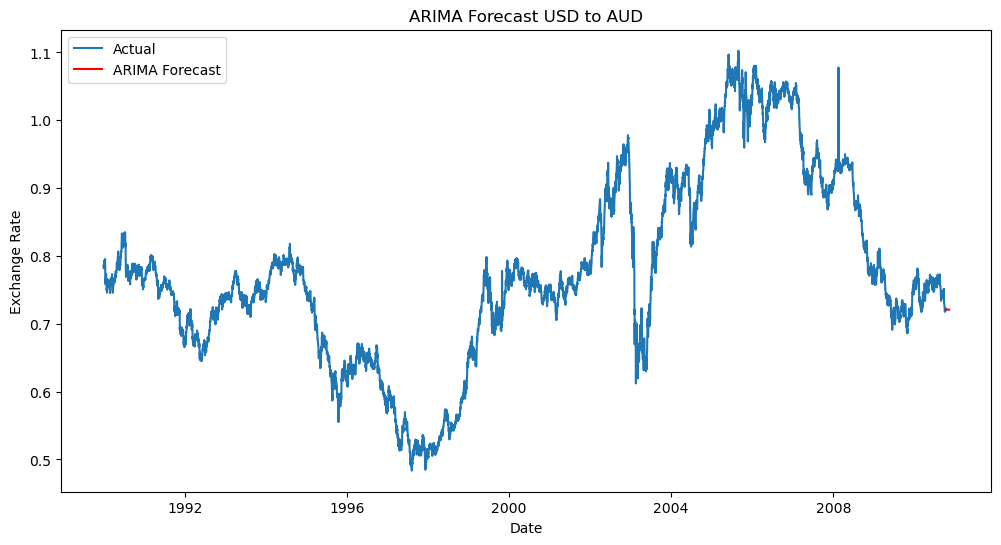

In [16]:
# Forecast next 30 days
forecast_arima = arima_result.forecast(steps=30)
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_arima, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast USD to AUD')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

## 4.Exponential Smoothing

In [17]:
# Fit Holt-Winters (Additive trend, no seasonality here)
exp_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
exp_result = exp_model.fit()
forecast_exp = exp_result.forecast(30)

E:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


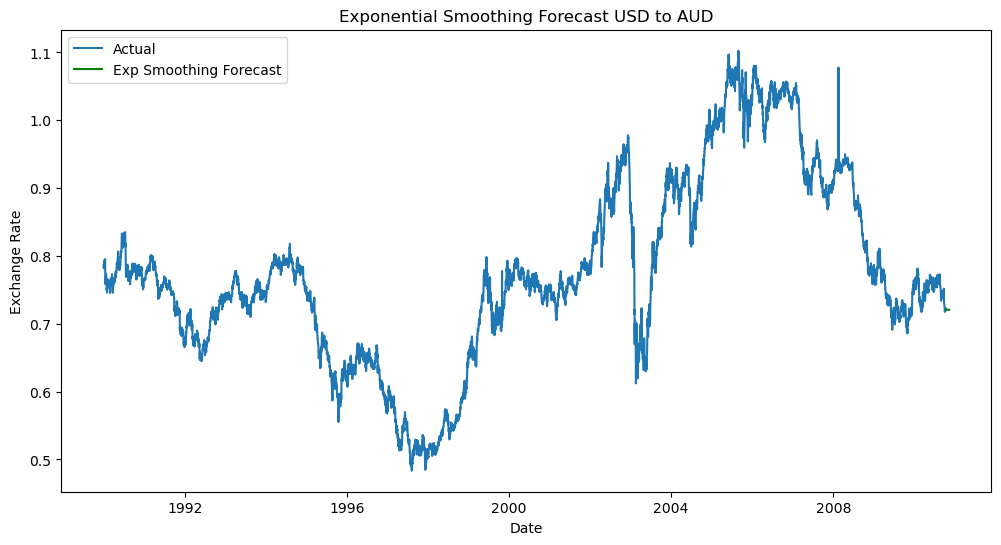

In [18]:
# Plot Exponential Smoothing forecast
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_exp, label='Exp Smoothing Forecast', color='green')
plt.title('Exponential Smoothing Forecast USD to AUD')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

## 5. Evaluation

In [19]:
# Compare last 30 days of actual data with forecast (if you want)
# Here we just use last 30 points for error calculation
actual = df['Ex_rate'][-30:]


In [20]:
# ARIMA Errors
mae_arima = mean_absolute_error(actual, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(actual, forecast_arima))
print(f'ARIMA MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}')

ARIMA MAE: 0.0127, RMSE: 0.0170


In [21]:
# Exponential Smoothing Errors
mae_exp = mean_absolute_error(actual, forecast_exp)
rmse_exp = np.sqrt(mean_squared_error(actual, forecast_exp))
print(f'Exp Smoothing MAE: {mae_exp:.4f}, RMSE: {rmse_exp:.4f}')

Exp Smoothing MAE: 0.0128, RMSE: 0.0170


## 6. Discussion

### 6. Model Evaluation and Comparison

**ARIMA:**
- Accuracy and residuals analysis indicate how well the model captures trends.
- Suitable for capturing short-term dependencies and autocorrelations.

**Exponential Smoothing:**
- Simple to implement, captures trend (additive) well.
- May not handle complex autocorrelations as ARIMA does.

**Error Metrics:**
- Compare MAE and RMSE of both models.
- Discuss which model performs better based on errors and visual alignment with actual data.

**Conclusion:**
- Summarize which model is better for forecasting USD to AUD.
- Mention limitations (no seasonality, external factors not considered).
